# NORTHWIND DATABASE

El **objetivo** de este ejercicio es generar una serie de consultas SQL que permitan extraer información relevante de la base de datos y luego exportar los resultados para construir dashboards o visualizaciones que proporcionen insights valiosos para la toma de decisiones empresariales.

La base de datos Northwind es una base de datos de ejemplo clásica que simula las operaciones de una empresa minorista. Contiene tablas relacionales que representan diferentes aspectos del negocio, como productos, clientes, pedidos y empleados. Utilizando consultas SQL, podrás explorar y analizar estos datos para comprender mejor el desempeño del negocio en diferentes áreas.

Una vez que hayas realizado las consultas SQL y obtenido los resultados, podrás utilizarlos para herramientas de visualización de datos como Tableau, Power BI, Streamlit o cualquier otra herramienta de tu elección. 

![img](./img/northwind-er-diagram.png)

Tendrás que elegir uno de los retos a resolver:

In [1]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine

import ibis
#con = ibis.pandas.connect()
 
import ibis
#con = ibis.sqlite.connect()



In [2]:
# Connect to the DB
conn = sqlite3.connect("./data/northwind.db")
c = conn.cursor()

#with open("./data/northwind_script.sql", 'r') as script:
#    lines = script.readlines()

c.execute("""PRAGMA foreign_keys = ON;""")

#c.executescript("".join(lines));

engine = create_engine('sqlite:///data/northwind.db', echo=False)
connection = engine.connect()


In [3]:
c.execute("""SELECT name FROM sqlite_master WHERE type='table';""").fetchall()

[('Categories',),
 ('sqlite_sequence',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographics',),
 ('Customers',),
 ('Employees',),
 ('EmployeeTerritories',),
 ('Order_Details',),
 ('Orders',),
 ('Products',),
 ('Regions',),
 ('Shippers',),
 ('Suppliers',),
 ('Territories',)]

In [4]:
# Con esta función leemos los datos y lo pasamos a un DataFrame de Pandas y ejecutamos una sentencia
def sql_query(query):

    # Ejecuta la query
    c.execute(query)

    # Almacena los datos de la query 
    ans = c.fetchall()

    # Obtenemos los nombres de las columnas de la tabla
    names = [description[0] for description in c.description]

    return pd.DataFrame(ans,columns=names)



###### ejemplo para ejecutar el def sql_query
# Nombre de la tabla de la que quieres obtener los campos
nombre_tabla = 'OrderDetails'

# Ejecutar la consulta PRAGMA para obtener la información de las columnas
query = f'PRAGMA table_info({nombre_tabla});'
df_columnas = sql_query(query)

# Mostrar el DataFrame con la información de las columnas
print(df_columnas)

Empty DataFrame
Columns: [cid, name, type, notnull, dflt_value, pk]
Index: []


In [5]:
query = """
SELECT count(*), OrderID, OrderDate
FROM invoices 
GROUP BY OrderDate
"""
pd.read_sql(query, con=connection)

,count(*),OrderID,OrderDate
0,41,18429,2012-07-10 15:40:46
1,47,25506,2012-07-10 20:28:57
2,70,26048,2012-07-11 01:09:16
3,31,16958,2012-07-11 20:26:28
4,49,25877,2012-07-11 21:17:36
...,...,...,...
15927,59,11298,2023-10-25 13:00:29
15928,70,23676,2023-10-26 06:28:53
15929,65,13789,2023-10-27 06:38:44
15930,29,25677,2023-10-27 18:17:38


In [6]:
res = c.execute("SELECT name FROM sqlite_master WHERE type='view'")
for name in res:
    print(name[0])

Alphabetical list of products
Current Product List
Customer and Suppliers by City
Invoices
Orders Qry
Order Subtotals
Product Sales for 1997
Products Above Average Price
Products by Category
Quarterly Orders
Sales Totals by Amount
Summary of Sales by Quarter
Summary of Sales by Year
Category Sales for 1997
Order Details Extended
ProductDetails_V
Sales by Category


### **1. Análisis de Ventas por Región**
Analiza las ventas de productos por región. El objetivo es identificar las regiones que generan más ingresos y las
 tendencias de ventas a lo largo del tiempo en esas regiones. 
Pista: Utiliza gráficos de barras y líneas para mostrar la evolución de las ventas, así como mapas geográficos para
 visualizar la distribución de ingresos por región.

In [7]:
#agrupado por region

query = """
SELECT ShipRegion, UnitPrice, Quantity, (UnitPrice * Quantity) AS Total_ventas
FROM Invoices
GROUP by ShipRegion
order by Total_ventas DESC
"""
df_sales_region = pd.read_sql(query, con=connection)
df_sales_region


,ShipRegion,UnitPrice,Quantity,Total_ventas
0,Northern Europe,15.2,35,532.0
1,Scandinavia,30.4,12,364.8
2,Eastern Europe,10.0,30,300.0
3,British Isles,8.0,30,240.0
4,North America,17.0,12,204.0
5,Western Europe,14.0,12,168.0
6,Central America,8.0,10,80.0
7,South America,7.7,10,77.0
8,Southern Europe,3.6,12,43.2


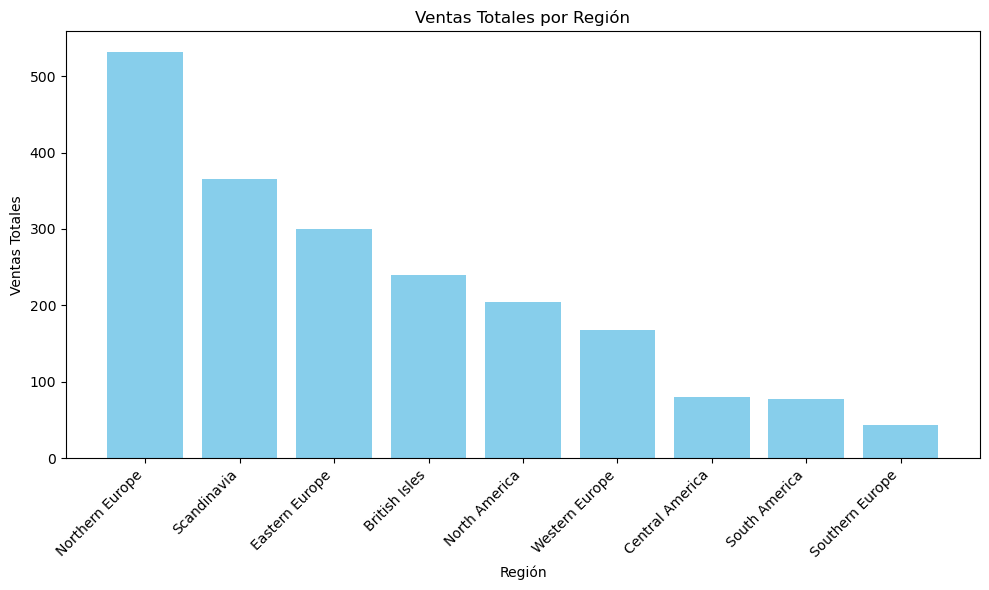

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_sales_region['ShipRegion'], df_sales_region['Total_ventas'], color='skyblue')
plt.xlabel('Región')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Región')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [96]:
#agrupado por pais

query = """
SELECT Country, UnitPrice, Quantity, (UnitPrice * Quantity) AS Total_ventas
FROM Invoices
GROUP by Country
order by Total_ventas DESC
"""
df_sales_country = pd.read_sql(query, con=connection)
df_sales_country
df_sales_country['Country'] = df_sales_country['Country'].fillna('Unknown')


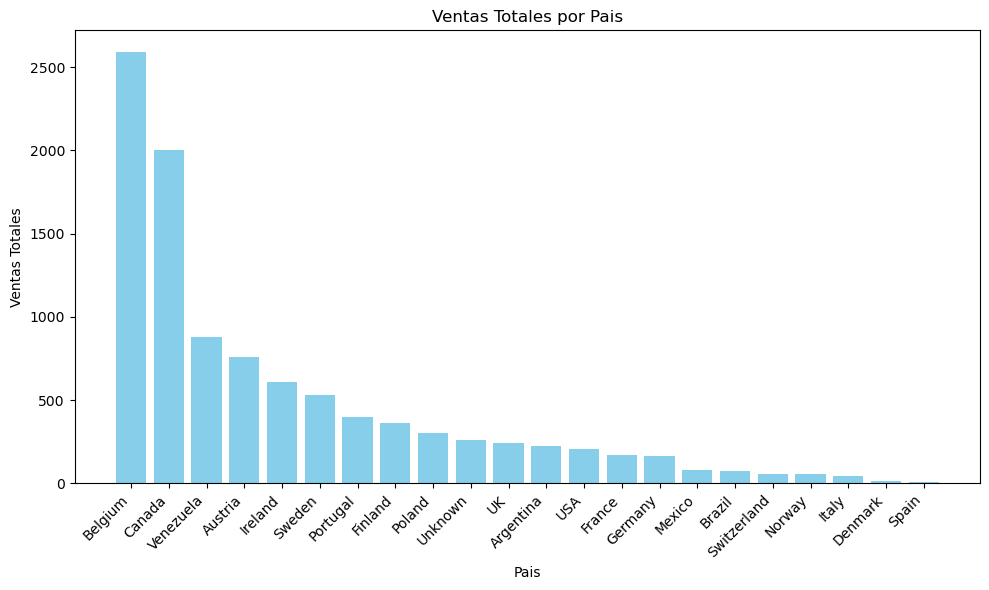

In [97]:


# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_sales_country['Country'], df_sales_country['Total_ventas'], color='skyblue')
plt.xlabel('Pais')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Pais')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [98]:
#agrupado por pais
query = """
SELECT strftime('%Y', ShippedDate) AS Year, (i.UnitPrice * i.Quantity) AS Total_ventas
FROM Invoices i 
WHERE Year IS NOT NULL
GROUP BY Year
ORDER BY Total_ventas asc;
"""
df_sales_OrderDate = pd.read_sql(query, con=connection)
df_sales_OrderDate

,Year,Total_ventas
0,2016,168.00
1,2014,323.00
2,2018,344.00
3,2017,372.60
4,2013,427.90
5,2022,449.50
6,2012,585.00
7,2020,589.00
8,2019,836.00
9,2023,901.00


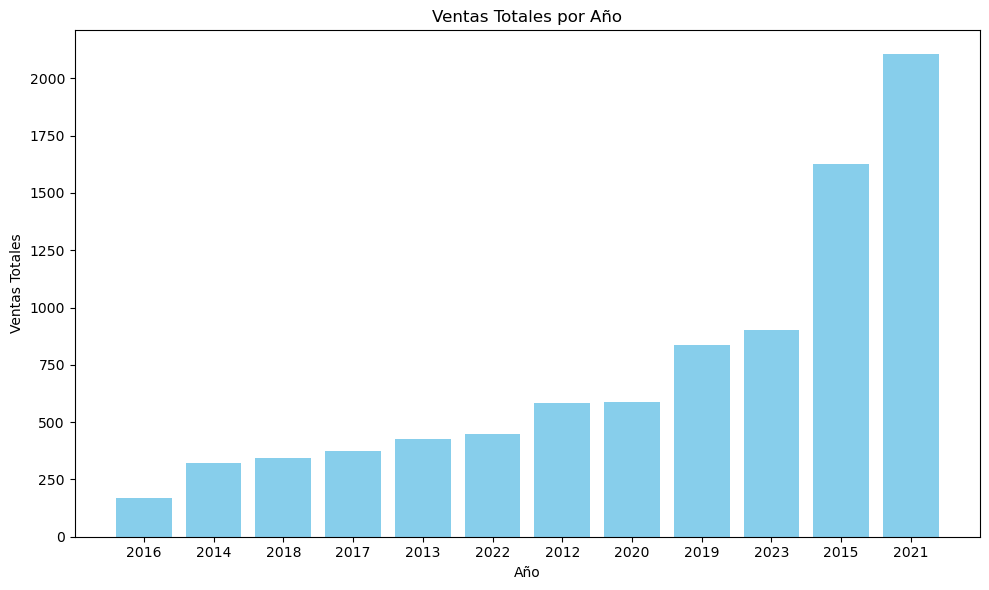

In [99]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_sales_OrderDate['Year'], df_sales_OrderDate['Total_ventas'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Año')
plt.xticks(df_sales_OrderDate['Year'])
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### **2. Análisis de Desempeño de Productos**
Analiza el desempeño de los productos de la empresa. Examina las ventas de productos por categoría, identificando los productos más vendidos y los menos vendidos. 

Pista: Utiliza gráficos de barras y de tarta para visualizar la participación de mercado de cada categoría y los ingresos generados por los productos individuales.

In [13]:
#ventas de productos por categoría  

query = """
SELECT 
    c.CategoryName,
    (i.UnitPrice * i.Quantity) AS Total_ventas
FROM 
    Categories c
JOIN 
    Products p ON c.CategoryID = p.CategoryID
JOIN 
    Invoices i ON p.ProductID = i.ProductID
GROUP BY 
    c.CategoryName;

"""
df_sales_CategoryName = pd.read_sql(query, con=connection)
df_sales_CategoryName

,CategoryName,Total_ventas
0,Beverages,604.8
1,Condiments,252.0
2,Confections,2592.0
3,Dairy Products,168.0
4,Grains/Cereals,98.0
5,Meat/Poultry,403.2
6,Produce,167.4
7,Seafood,77.0


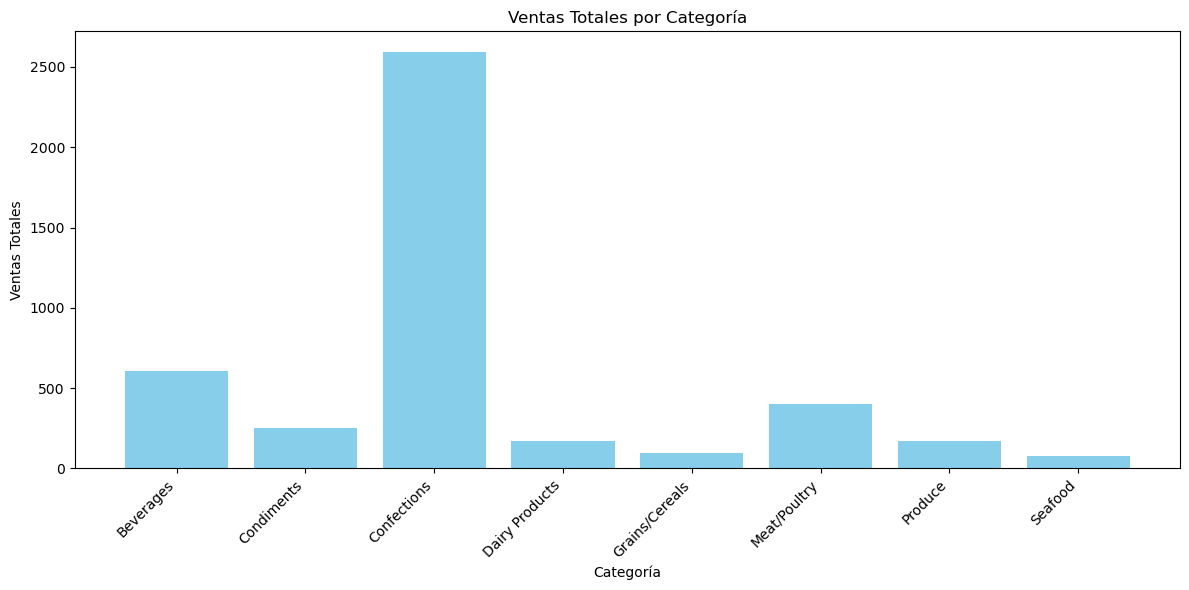

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_sales_CategoryName['CategoryName'], df_sales_CategoryName['Total_ventas'], color='skyblue')
plt.xlabel('Categoría')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Categoría')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

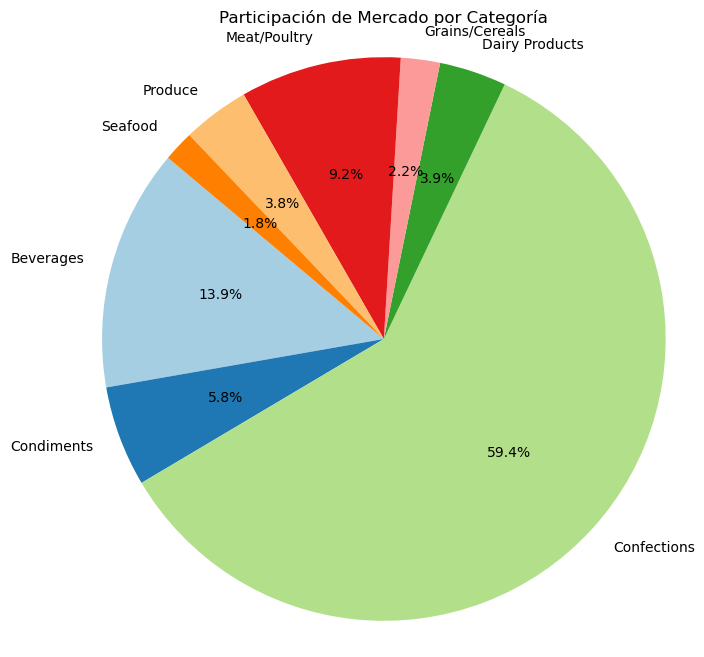

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(df_sales_CategoryName['Total_ventas'], labels=df_sales_CategoryName['CategoryName'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Participación de Mercado por Categoría')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.show()


In [41]:
#ventas de productos por categoria

query = """
SELECT 
    c.CategoryName,
    p.ProductName,
    (i.UnitPrice * i.Quantity) AS Total_ventas
FROM 
    Categories c
JOIN 
    Products p ON c.CategoryID = p.CategoryID
JOIN 
    Invoices i ON p.ProductID = i.ProductID
GROUP BY 
    c.CategoryName, p.ProductName;

"""
df_sales_CategoryProduct = pd.read_sql(query, con=connection)
df_sales_CategoryProduct

,CategoryName,ProductName,Total_ventas
0,Beverages,Chai,648.0
1,Beverages,Chang,304.0
2,Beverages,Chartreuse verte,604.8
3,Beverages,Côte de Blaye,4216.0
4,Beverages,Guaraná Fantástica,54.0
...,...,...,...
72,Seafood,Konbu,48.0
73,Seafood,Nord-Ost Matjeshering,1242.0
74,Seafood,Rogede sild,114.0
75,Seafood,Röd Kaviar,300.0


C:\Users\amejo\AppData\Local\Temp\ipykernel_7804\104206378.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


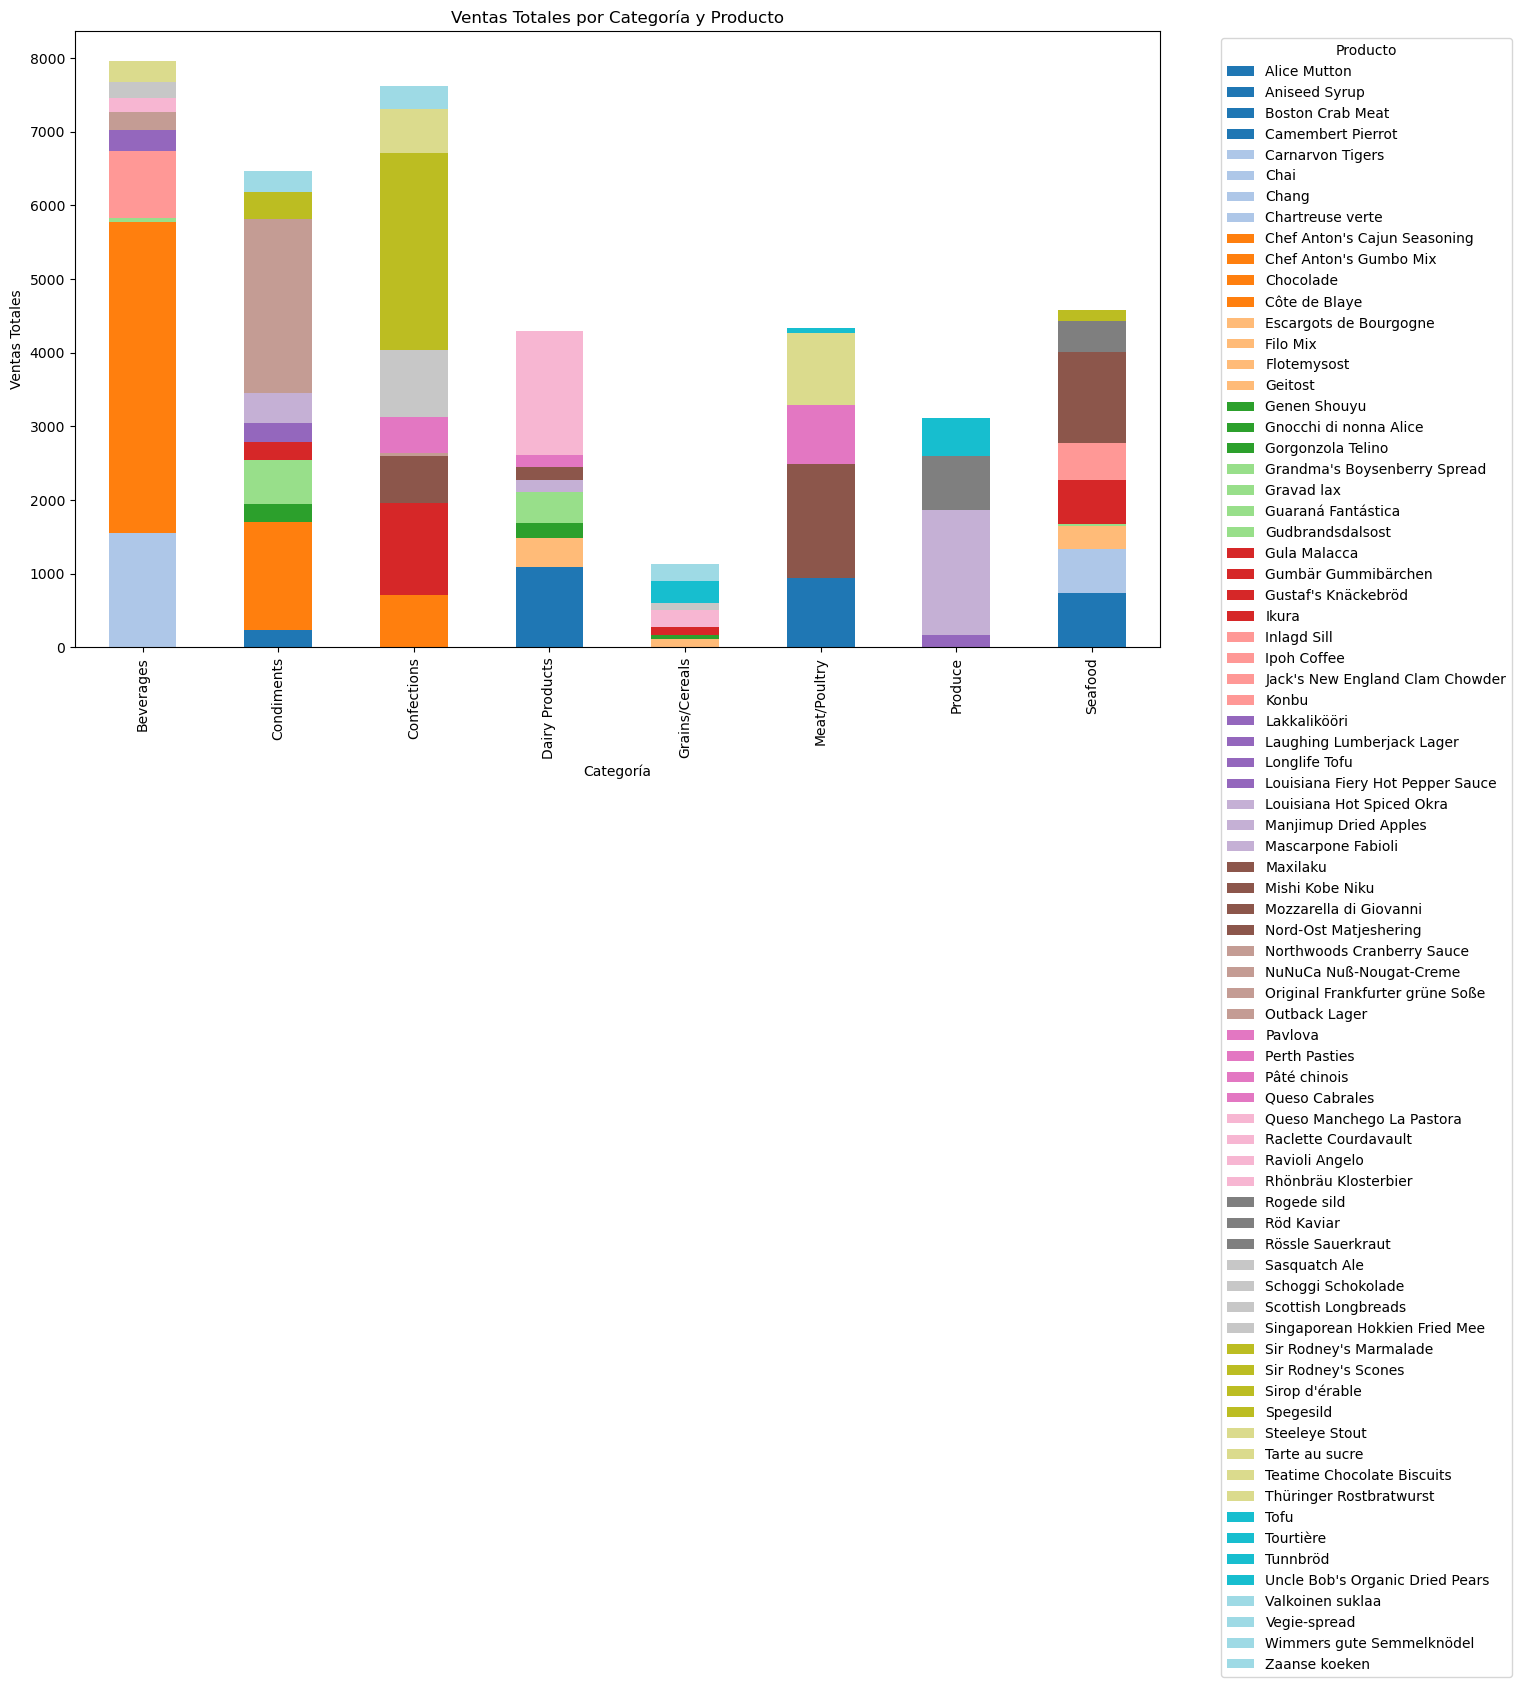

In [49]:
import pandas as pd
import matplotlib.pyplot as plt


# Pivotar los datos para el gráfico de barras apiladas
pivot_df = df_sales_CategoryProduct.pivot(index='CategoryName', columns='ProductName', values='Total_ventas').fillna(0)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')
plt.xlabel('Categoría')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Categoría y Producto')
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [52]:
#ventas de productos 

query = """
SELECT 
    c.CategoryName,
    p.ProductName,
    SUM(i.UnitPrice * i.Quantity) AS Total_ventas
FROM 
    Categories c
JOIN 
    Products p ON c.CategoryID = p.CategoryID
JOIN 
    Invoices i ON p.ProductID = i.ProductID
WHERE 
    c.CategoryName = 'Beverages'
GROUP BY 
    c.CategoryName, p.ProductName;


"""
df_sales_CategoryBeverages = pd.read_sql(query, con=connection)
df_sales_CategoryBeverages

,CategoryName,ProductName,Total_ventas
0,Beverages,Chai,3633663.60
1,Beverages,Chang,3832714.20
2,Beverages,Chartreuse verte,3635182.80
3,Beverages,Côte de Blaye,53274482.70
4,Beverages,Guaraná Fantástica,908535.60
5,Beverages,Ipoh Coffee,9334927.20
6,Beverages,Lakkalikööri,3625740.00
7,Beverages,Laughing Lumberjack Lager,2821560.00
8,Beverages,Outback Lager,3065262.00
9,Beverages,Rhönbräu Klosterbier,1557612.05


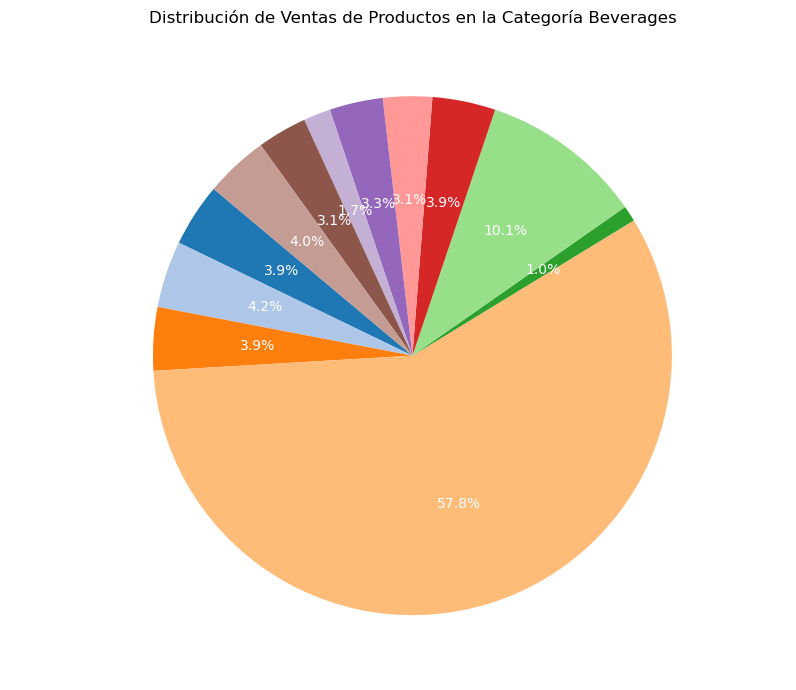

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df_sales_CategoryBeverages es el DataFrame con los datos proporcionados

# Calcular la suma total de ventas por categoría
category_totals = df_sales_CategoryBeverages.groupby('CategoryName')['Total_ventas'].sum()

# Calcular la proporción de ventas de cada producto dentro de su categoría
df_sales_CategoryBeverages['Proportion'] = df_sales_CategoryBeverages.apply(lambda row: row['Total_ventas'] / category_totals[row['CategoryName']], axis=1)

# Configurar la figura para una sola categoría
plt.figure(figsize=(10, 7))
data = df_sales_CategoryBeverages[df_sales_CategoryBeverages['CategoryName'] == 'Beverages']

# Crear el gráfico de torta para la categoría 'Beverages'
plt.pie(data['Total_ventas'], labels=data['ProductName'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors, textprops=dict(color="w"))
plt.title('Distribución de Ventas de Productos en la Categoría Beverages')
plt.tight_layout()

# Mostrar el gráfico
plt.show()



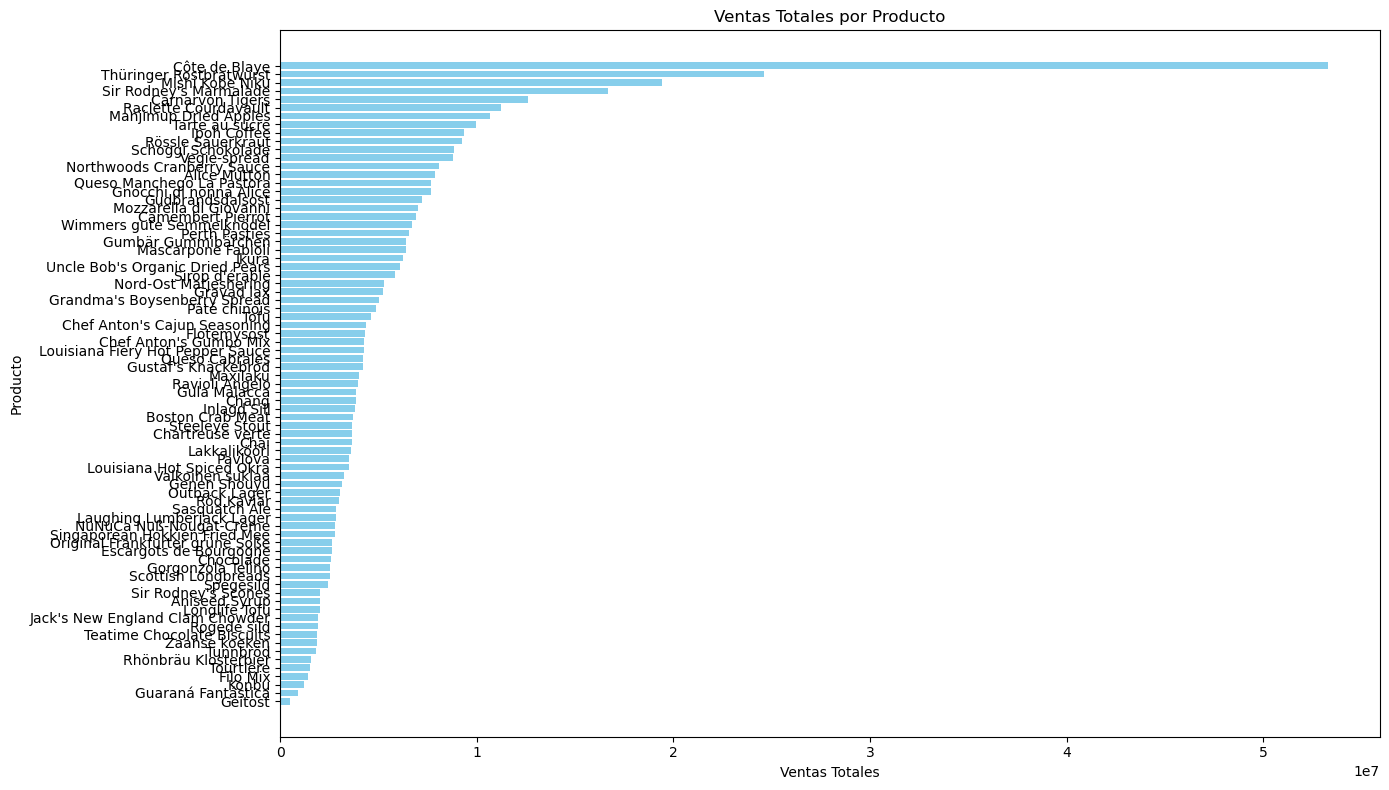

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df_sales_CategoryProduct es el DataFrame con los datos proporcionados

# Crear el gráfico de barras para los productos más vendidos
plt.figure(figsize=(14, 8))
plt.barh(df_sales_CategoryProduct['ProductName'], df_sales_CategoryProduct['Total_ventas'], color='skyblue')
plt.xlabel('Ventas Totales')
plt.ylabel('Producto')
plt.title('Ventas Totales por Producto')
plt.gca().invert_yaxis()  # Invertir el eje y para que el más vendido aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()



In [26]:
#identificando los productos más vendidos.

query = """

SELECT 
    i.ProductName,  
    (i.UnitPrice * i.Quantity) AS Total_ventas,
    'Most Sold' as SaleType
FROM 
    Invoices i
GROUP BY 
    i.ProductName
ORDER BY  
    Total_ventas DESC
LIMIT 10;
"""
df_sales_MaxCategoryProduct = pd.read_sql(query, con=connection)
df_sales_MaxCategoryProduct

,ProductName,Total_ventas,SaleType
0,Côte de Blaye,4216.0,Most Sold
1,Sir Rodney's Marmalade,2592.0,Most Sold
2,Northwoods Cranberry Sauce,2240.0,Most Sold
3,Manjimup Dried Apples,1696.0,Most Sold
4,Mishi Kobe Niku,1552.0,Most Sold
5,Raclette Courdavault,1320.0,Most Sold
6,Gumbär Gummibärchen,1245.0,Most Sold
7,Nord-Ost Matjeshering,1242.0,Most Sold
8,Chef Anton's Gumbo Mix,1105.0,Most Sold
9,Camembert Pierrot,1088.0,Most Sold


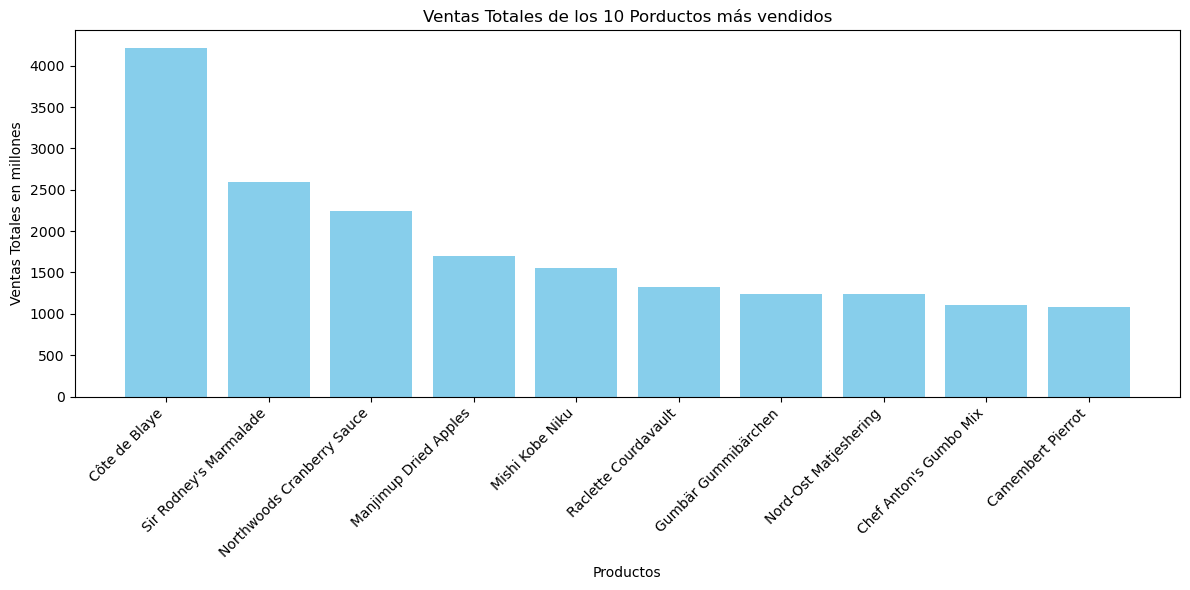

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_sales_MaxCategoryProduct['ProductName'], df_sales_MaxCategoryProduct['Total_ventas'], color='skyblue')
plt.xlabel('Productos')
plt.ylabel('Ventas Totales en millones')
plt.title('Ventas Totales de los 10 Porductos más vendidos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

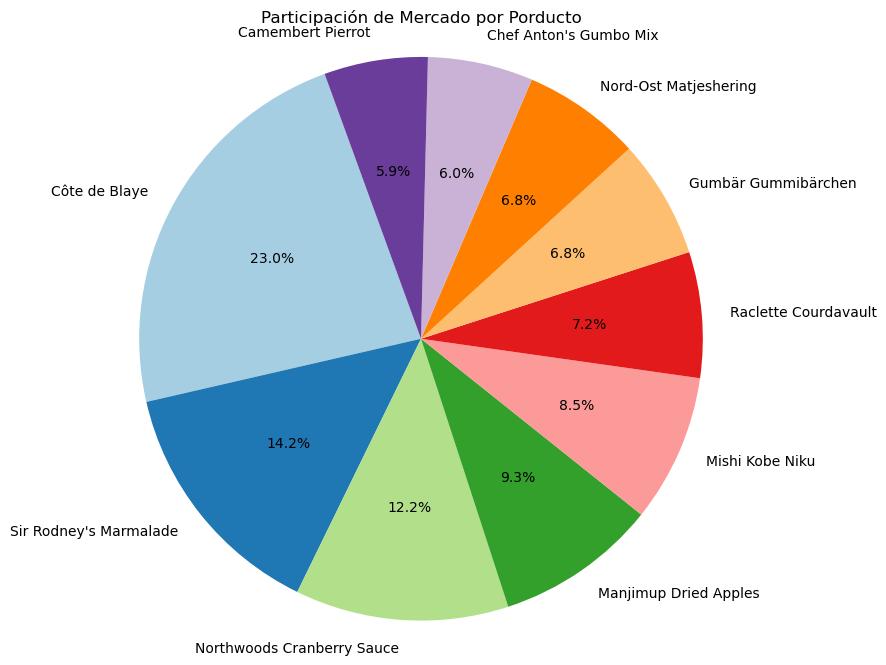

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(df_sales_MaxCategoryProduct['Total_ventas'], labels=df_sales_MaxCategoryProduct['ProductName'], autopct='%1.1f%%', startangle=110, colors=plt.cm.Paired.colors)
plt.title('Participación de Mercado por Porducto')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.show()

In [30]:
#identificando los productos menos vendidos.

query = """
SELECT 
    i.ProductName,  
    SUM(i.UnitPrice * i.Quantity) AS Total_ventas,
    'Least Sold' as SaleType
FROM 
    Invoices i
GROUP BY 
    i.ProductName
ORDER BY  
    Total_ventas ASC
LIMIT 10;
"""
df_sales_MinCategoryProduct = pd.read_sql(query, con=connection)
df_sales_MinCategoryProduct

,ProductName,Total_ventas,SaleType
0,Geitost,507186.00,Least Sold
1,Guaraná Fantástica,908535.60,Least Sold
2,Konbu,1214882.40,Least Sold
3,Filo Mix,1421520.80,Least Sold
4,Tourtière,1509521.85,Least Sold
5,Rhönbräu Klosterbier,1557612.05,Least Sold
6,Tunnbröd,1818844.20,Least Sold
7,Zaanse koeken,1879696.60,Least Sold
8,Teatime Chocolate Biscuits,1889988.30,Least Sold
9,Rogede sild,1904294.00,Least Sold


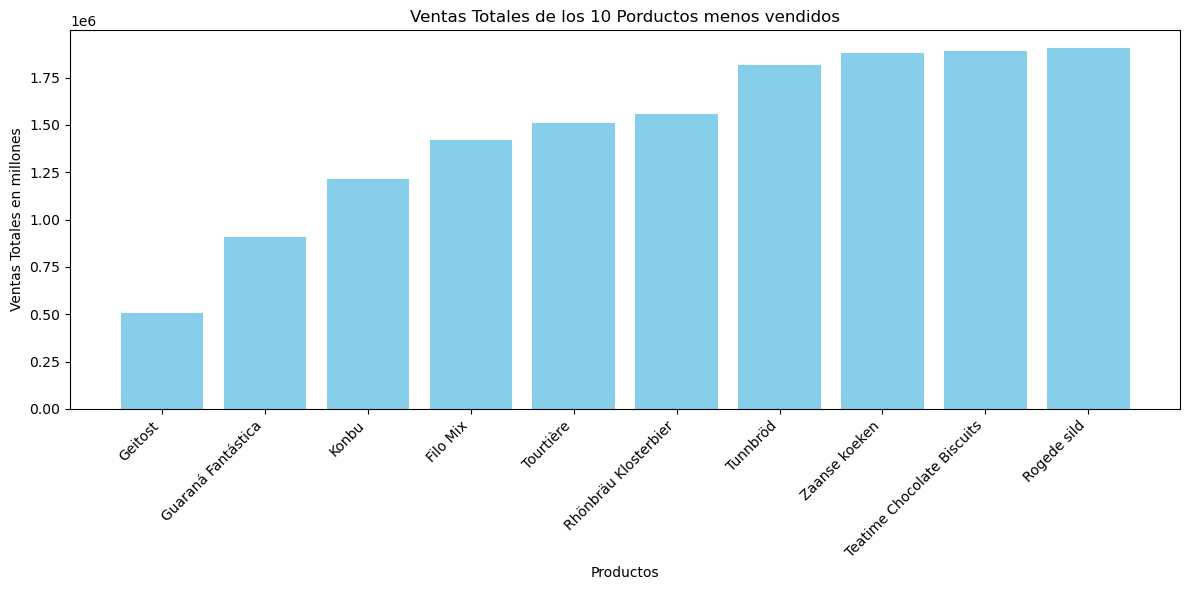

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_sales_MinCategoryProduct['ProductName'], df_sales_MinCategoryProduct['Total_ventas'], color='skyblue')
plt.xlabel('Productos')
plt.ylabel('Ventas Totales en millones')
plt.title('Ventas Totales de los 10 Porductos menos vendidos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

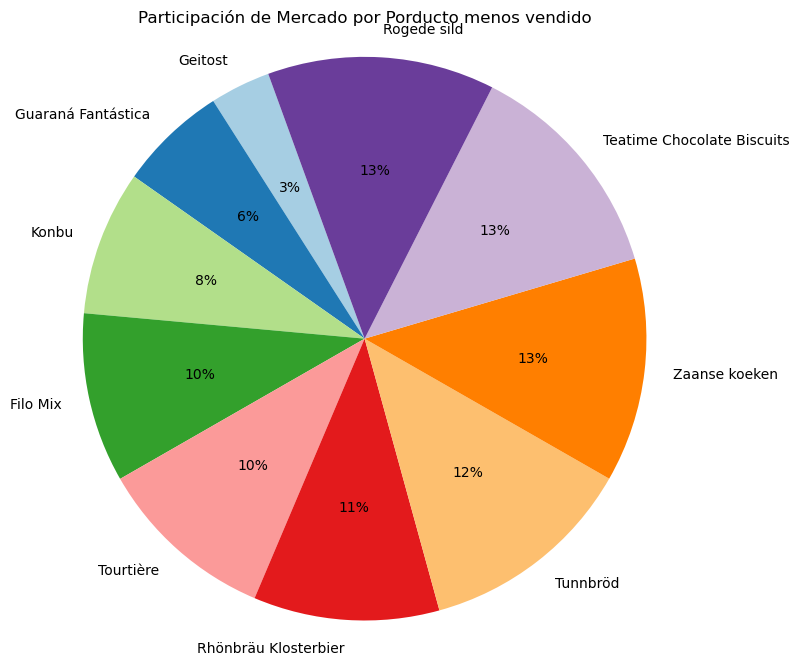

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(df_sales_MinCategoryProduct['Total_ventas'], labels=df_sales_MinCategoryProduct['ProductName'], autopct='%1.1f%%', startangle=110, colors=plt.cm.Paired.colors)
plt.title('Participación de Mercado por Porducto menos vendido')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.show()

### **3. Análisis de Rentabilidad de Clientes**
Analiza la rentabilidad de los clientes de la empresa. Examina los ingresos generados por cada cliente, así como los costos asociados con el servicio o producto proporcionado. 

Pista: Utiliza gráficos de dispersión y tablas dinámicas para identificar los clientes más rentables y aquellos que requieren mayor atención.

In [86]:
#identificando la ventas para cada cliente.

query = """
SELECT 
    strftime('%Y', OrderDate) AS Year,
    CustomerName,
    UnitPrice,
    Quantity,
    Discount,
    (UnitPrice * Quantity * (1 - Discount)) AS TotalSales
FROM 
    Invoices
GROUP BY 
    Year, CustomerName
ORDER BY 
    Year, CustomerName;

"""
df_sales_year_customer = pd.read_sql(query, con=connection)
df_sales_year_customer

,Year,CustomerName,UnitPrice,Quantity,Discount,TotalSales
0,2012,Alfreds Futterkiste,14.00,39,0.0,546.00
1,2012,Ana Trujillo Emparedados y helados,18.00,15,0.0,270.00
2,2012,Antonio Moreno Taquería,17.00,40,0.0,680.00
3,2012,Around the Horn,21.50,40,0.0,860.00
4,2012,B's Beverages,31.00,30,0.0,930.00
...,...,...,...,...,...,...
1099,2023,Wartian Herkku,49.30,10,0.0,493.00
1100,2023,Wellington Importadora,20.00,43,0.0,860.00
1101,2023,White Clover Markets,20.00,30,0.0,600.00
1102,2023,Wilman Kala,123.79,13,0.0,1609.27


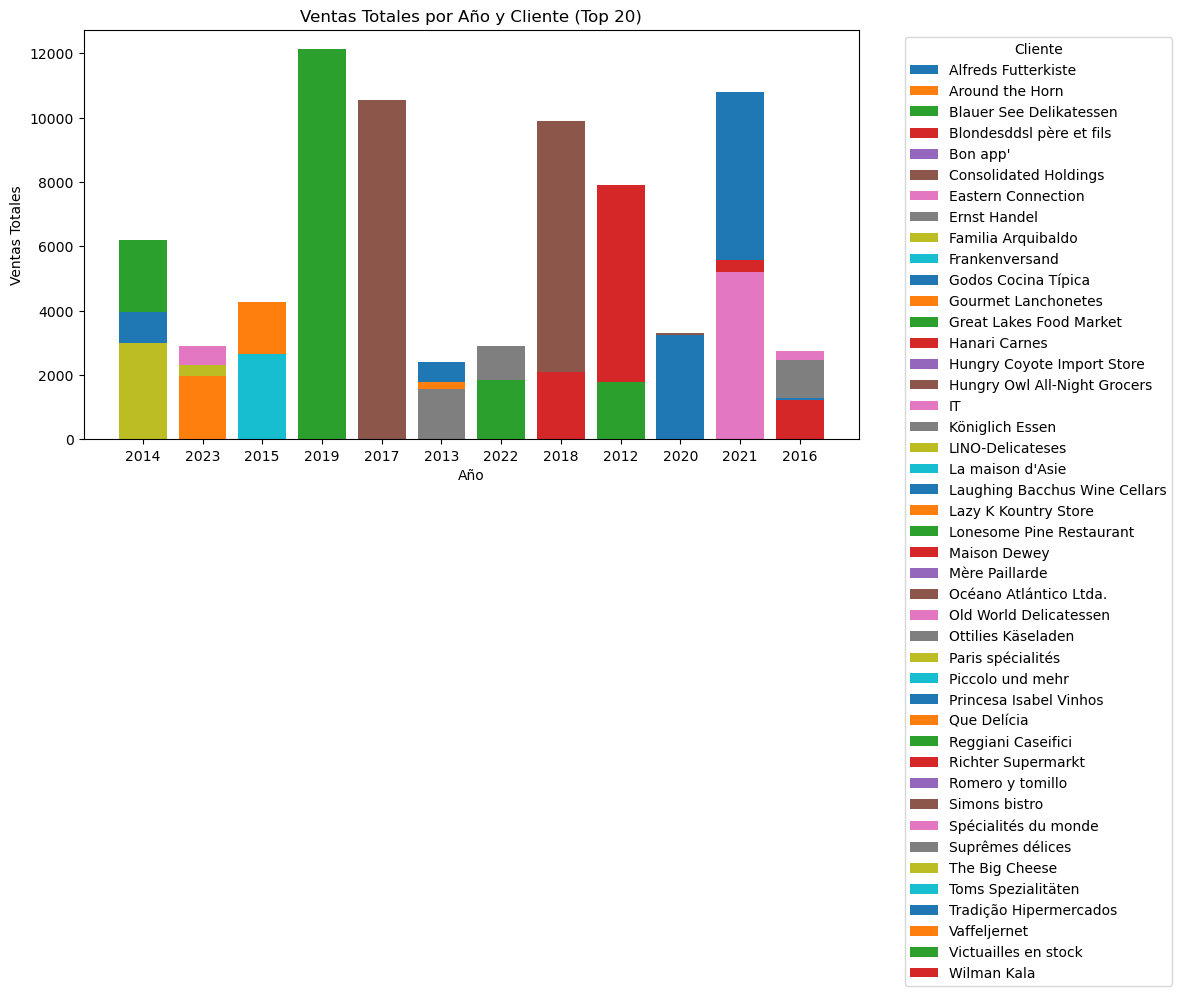

In [88]:
import pandas as pd
import matplotlib.pyplot as plt


# Calcular las ventas totales por cliente y año
df_sales_year_customer['TotalSales'] = df_sales_year_customer['UnitPrice'] * df_sales_year_customer['Quantity'] * (1 - df_sales_year_customer['Discount'])
customer_sales = df_sales_year_customer.groupby(['Year', 'CustomerName'])['TotalSales'].sum().reset_index()

# Seleccionar los 20 mejores clientes por ventas totales para cada año
top_customers_per_year = customer_sales.groupby('Year').apply(lambda x: x.nlargest(5, 'TotalSales')).reset_index(drop=True)

# Configurar el gráfico de barras
plt.figure(figsize=(12, 8))
for customer, data in top_customers_per_year.groupby('CustomerName'):
    plt.bar(data['Year'], data['TotalSales'], label=customer)

# Añadir detalles al gráfico
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Año y Cliente (Top 5)')
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


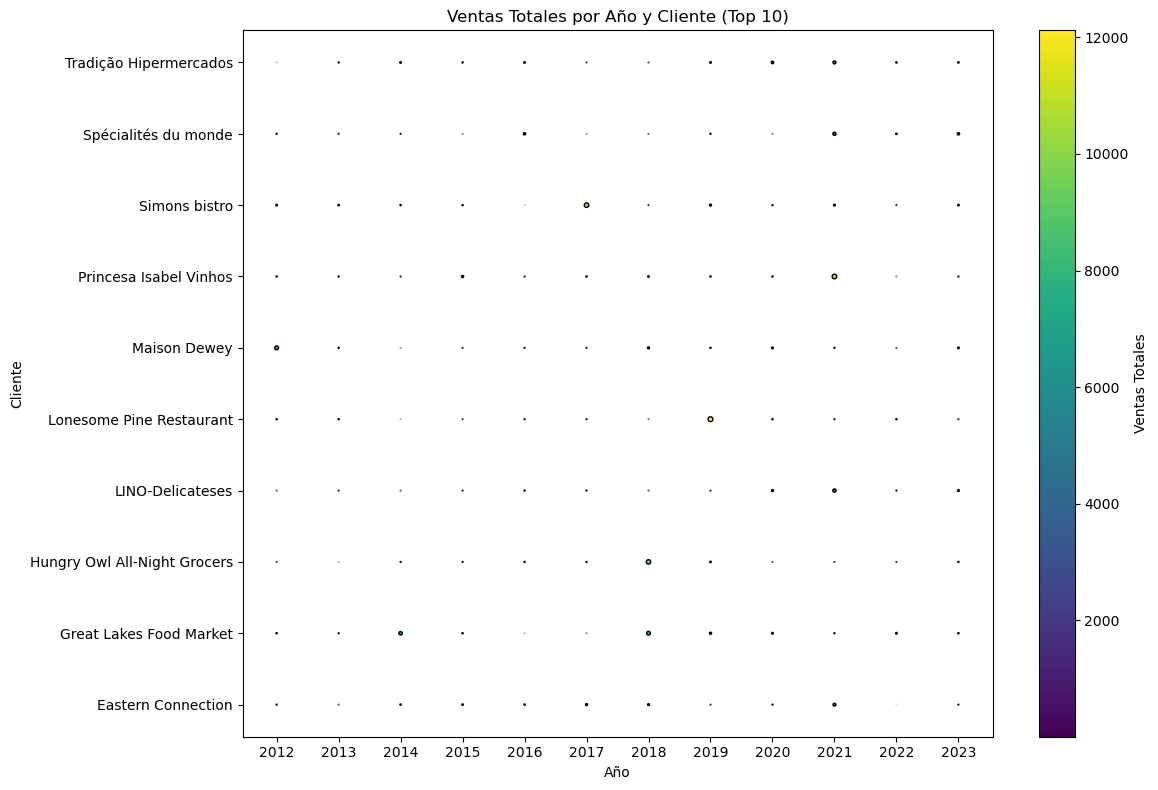

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular las ventas totales por cliente
customer_sales = df_sales_year_customer.groupby('CustomerName')['TotalSales'].sum()

# Seleccionar los 20 mejores clientes por ventas totales
top_customers = customer_sales.nlargest(10).index

# Filtrar el DataFrame original para incluir solo los datos de los 20 mejores clientes
df_top_customers = df_sales_year_customer[df_sales_year_customer['CustomerName'].isin(top_customers)]

# Crear el gráfico de dispersión para los 20 mejores clientes
plt.figure(figsize=(12, 8))
plt.scatter(df_top_customers['Year'], df_top_customers['CustomerName'], s=df_top_customers['TotalSales']/1000, alpha=1.0, cmap='viridis', c=df_top_customers['TotalSales'], edgecolor='black', linewidth=1)
plt.colorbar(label='Ventas Totales')
plt.xlabel('Año')
plt.ylabel('Cliente')
plt.title('Ventas Totales por Año y Cliente (Top 10)')
plt.grid(False)  # Eliminar las líneas de la cuadrícula
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Figure size 1400x800 with 0 Axes>

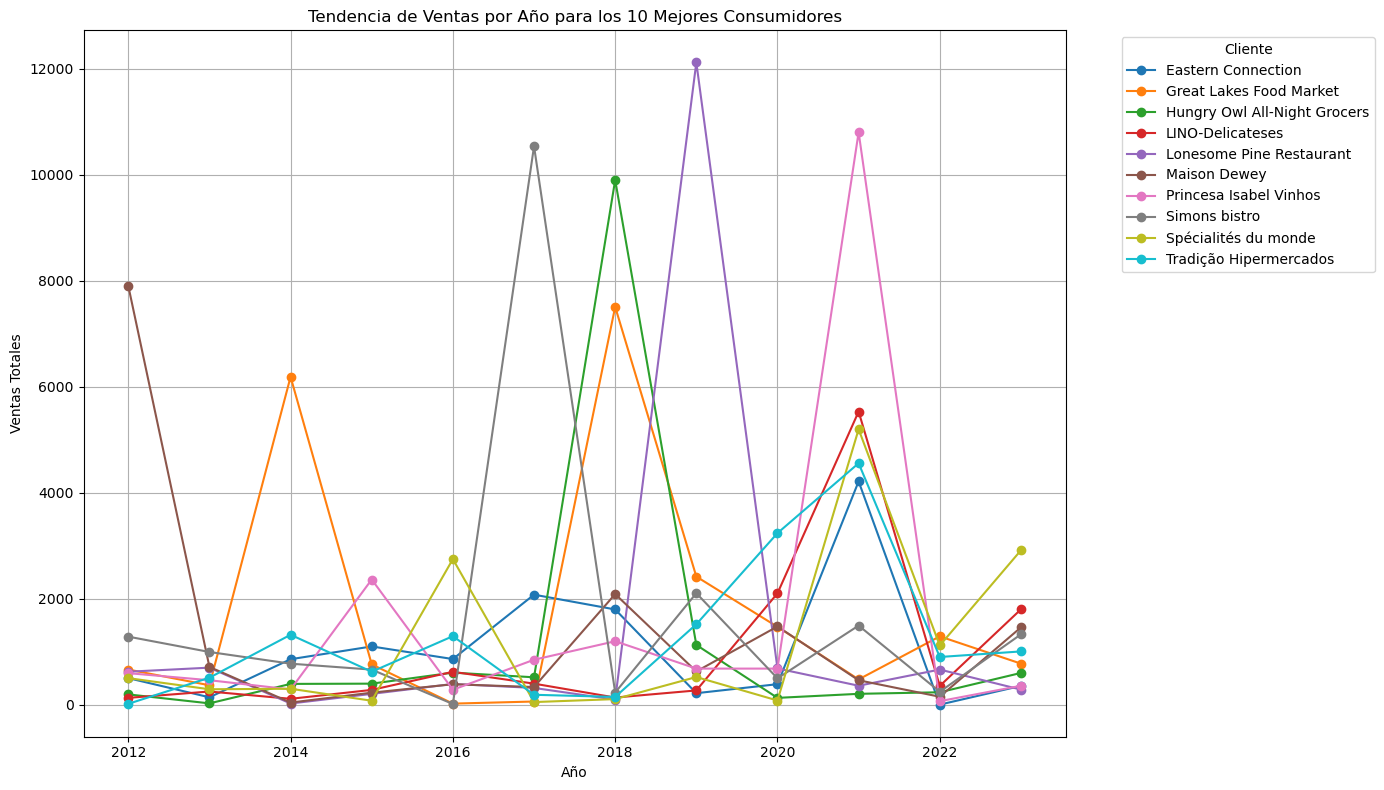

In [94]:
# grafico de linea
# Ventas Totales por Año para los 10 Mejores Consumidores

import pandas as pd
import matplotlib.pyplot as plt


# Calcular las ventas totales por cliente
customer_sales = df_sales_year_customer.groupby('CustomerName')['TotalSales'].sum()

# Seleccionar los 20 mejores consumidores por ventas totales
top_customers = customer_sales.nlargest(10).index

# Filtrar el DataFrame para incluir solo los datos de los 20 mejores consumidores
df_top_customers = df_sales_year_customer[df_sales_year_customer['CustomerName'].isin(top_customers)]

# Pivote los datos para el gráfico de líneas
pivot_df = df_top_customers.pivot(index='Year', columns='CustomerName', values='TotalSales').fillna(0)

# Crear el gráfico de líneas
plt.figure(figsize=(14, 8))
pivot_df.plot(kind='line', figsize=(14, 8), marker='o')
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.title('Tendencia de Ventas por Año para los 10 Mejores Consumidores')
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


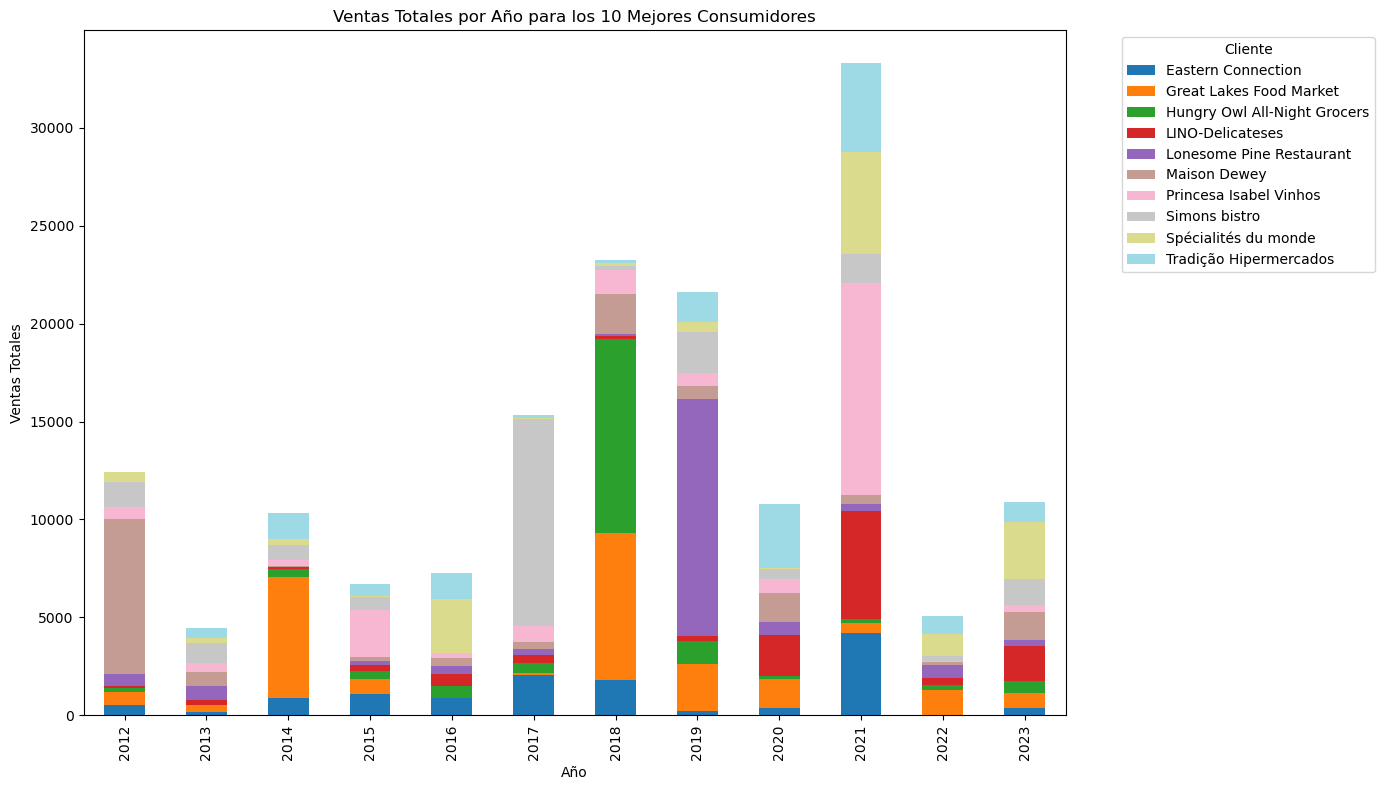

In [95]:
# grafico de barra apiladas
# Ventas Totales por Año para los 10 Mejores Consumidores

import pandas as pd
import matplotlib.pyplot as plt

# Calcular las ventas totales por cliente
customer_sales = df_sales_year_customer.groupby('CustomerName')['TotalSales'].sum()

# Seleccionar los 20 mejores consumidores por ventas totales
top_customers = customer_sales.nlargest(10).index

# Filtrar el DataFrame para incluir solo los datos de los 20 mejores consumidores
df_top_customers = df_sales_year_customer[df_sales_year_customer['CustomerName'].isin(top_customers)]

# Pivote los datos para el gráfico de barras apiladas
pivot_df = df_top_customers.pivot(index='Year', columns='CustomerName', values='TotalSales').fillna(0)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20')
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Año para los 10 Mejores Consumidores')
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### **4. Análisis de Inventarios y Proveedores**
Analiza los niveles de inventario y la gestión de proveedores de la empresa. Examina el inventario disponible por categoría de productos, así como el rendimiento de los proveedores en términos de puntualidad de entrega y calidad de los productos. 

Pista: Utiliza gráficos de líneas y tablas dinámicas para mostrar tendencias y comparar el desempeño de los proveedores.


### **5. Análisis de Comportamiento de Empleados**
Analiza el comportamiento de los empleados de la empresa. Examina las ventas realizadas por cada empleado, así como su eficiencia en el manejo de pedidos y su puntualidad en la entrega de productos. 

Pista: Utiliza gráficos de barra y de dispersión para comparar el desempeño de los empleados y identificar áreas de mejora.

In [ ]:
# Cerrar la conexión con sqlite3
c.close()  # Cerrar el cursor
conn.close()  # Cerrar la conexión


# Tu código para trabajar con la BD usando SQLAlchemy...

# Cerrar la conexión con SQLAlchemy
connection.close()
